# Chapter 2: End-to-End Machine Learning Project
This work is partialy combined text and code from the book [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) and is only supposed to be used as reference and recommended to follow along with a copy of the Book puchased.

In [ ]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Fetch the data & load into DataFrame

In [ ]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path, exist_ok = True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path = HOUSING_PATH):
    fetch_housing_data()
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [ ]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Exploratory Analysis

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


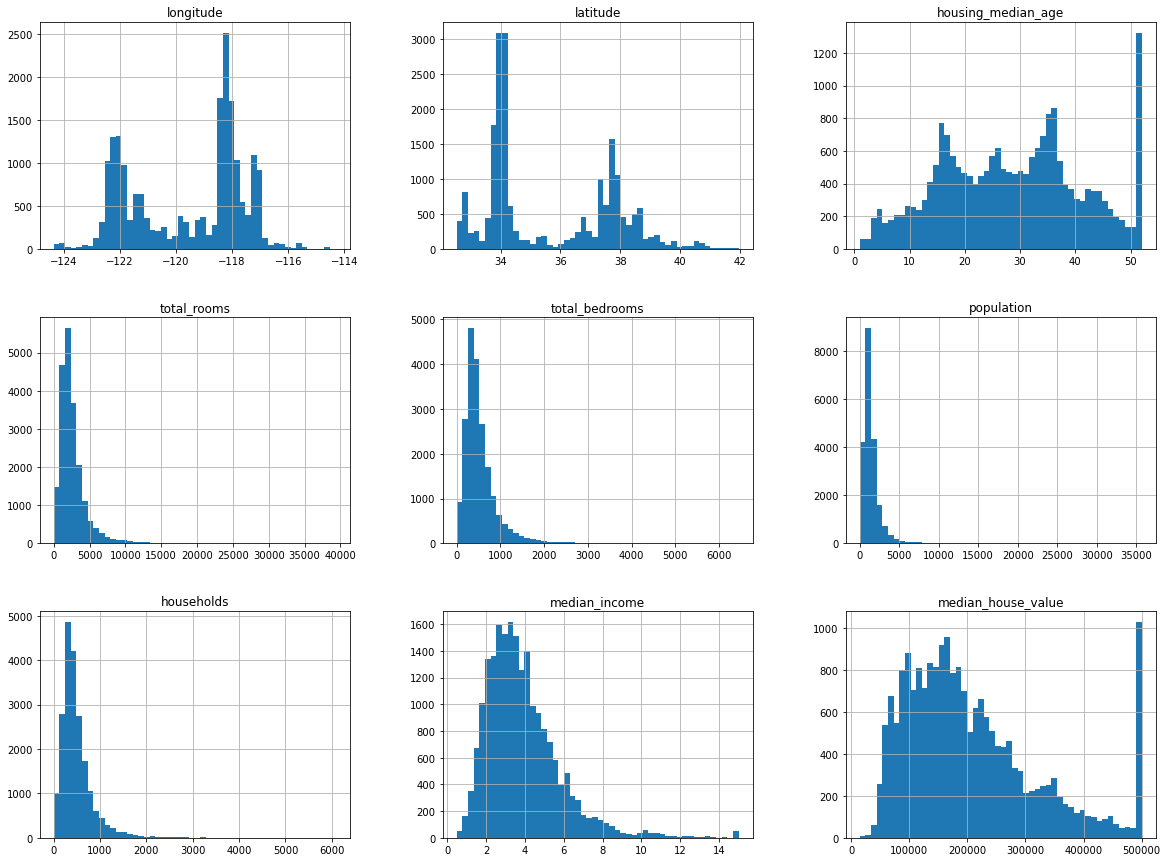

In [ ]:
_=housing.hist(bins = 50, figsize=(20,15))

### Create Test Set

**Avoid Snooping Bias**: If you stumble upon seemingly interesting pattern in the test data that leads to select a particular kind of ML model, gereneralization error using the test set, your estimate will be *too optimistic*. And if the system is launched, will not perform as expected. 

In [ ]:
from zlib import crc32


def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)* test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

def print_len_of_sets(train_set, test_set,identifier=None):
    if identifier:
        print('Using',identifier)
    print('Train set length:', len(train_set))
    print('Test set length:', len(test_set))
    print()

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
train_set, test_set = split_train_test(housing, 0.2)
print_len_of_sets(train_set, test_set,'split_train_test')

housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2,'index')
print_len_of_sets(train_set, test_set, 'split_train_test_by_id')

Using split_train_test
Train set length: 16512
Test set length: 4128

Using split_train_test_by_id
Train set length: 16512
Test set length: 4128



You Need to make sure that:
1. New data gets appended at the end
2. No row ever gets deleted

If ***NOT*** **Use most stable features to build the unique identifier**

In [ ]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2,'id')
print_len_of_sets(train_set,test_set,'split_train_test_by_id & builded identifier')

Using split_train_test_by_id & builded identifier
Train set length: 16322
Test set length: 4318



In [ ]:
from sklearn.model_selection import train_test_split


train_test, test_test = train_test_split(housing, test_size=0.2, random_state=42)
print_len_of_sets(train_set, test_set,'SKlearn train_test_split')

Using SKlearn train_test_split
Train set length: 16322
Test set length: 4318



>**Stratified Sampling**: The population is divided into homogenous subgroups called *strata*.

You should **NOT have too many strata**, and each stratum should be arge enough.

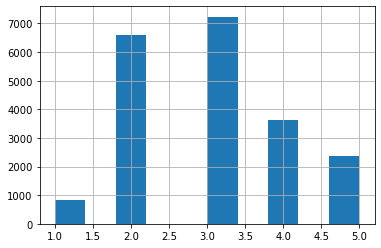

In [ ]:
housing['income_cat'] = pd.cut(housing['median_income'],
                              bins=[0,1.5,3.0,4.5,6.,np.inf],
                              labels=[1,2,3,4,5])
_=housing['income_cat'].hist()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in stratified_split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set['income_cat'].value_counts()

3    1447
2    1316
4     728
5     473
1     164
Name: income_cat, dtype: int64

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

### Discover and Visualize the Data to gain Insights

In [ ]:
houing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

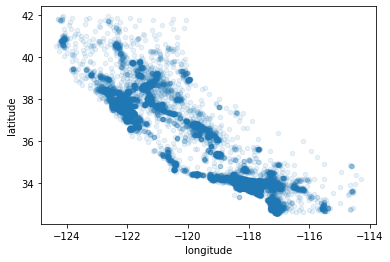

In [ ]:
housing.plot(kind='scatter',x='longitude', y='latitude', alpha=0.1)

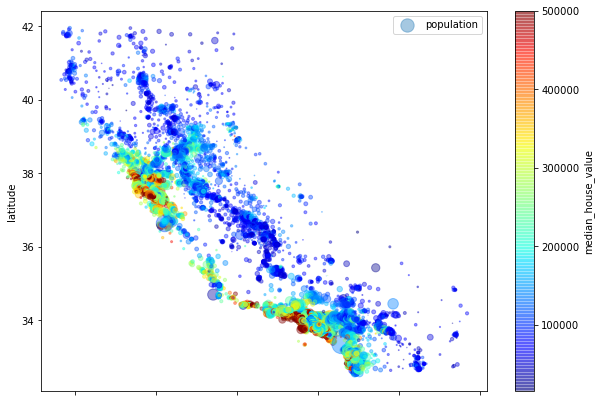

In [ ]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population', figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

California housing prices: red is expensive, blue is cheap, larger circles indicate areas with larger population

In [ ]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

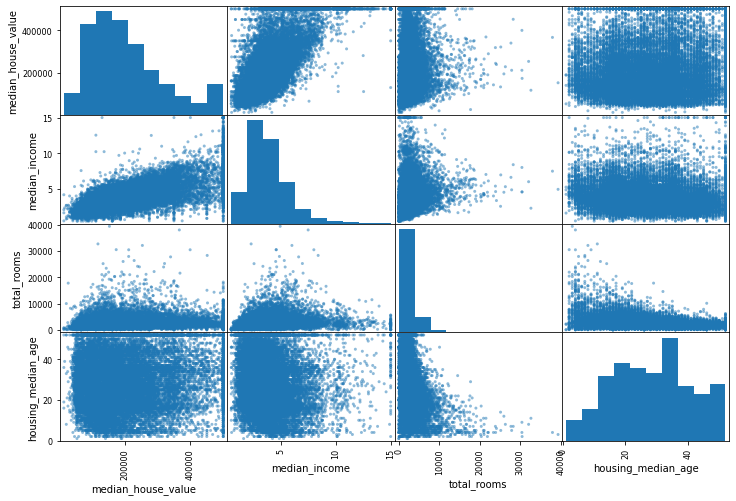

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
_=scatter_matrix(housing[attributes], figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

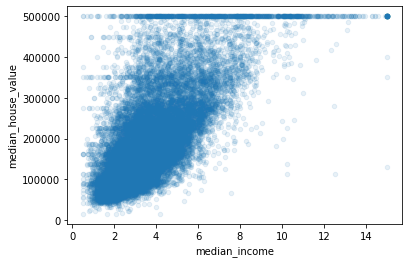

In [ ]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

### Expermenting with Attribute Combinations

In [ ]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedroom_per_household'] = housing['total_bedrooms']/housing['households'] 
housing['population_per_household'] = housing['population']/housing['households']
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedroom_per_household,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,1.035398,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.008850,0.955752,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,1.019481,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,1.050992,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.505810,1.042379,3.047847


In [ ]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
bedroom_per_household      -0.046739
latitude                   -0.144160
Name: median_house_value, dtype: float64

### Prepare the data for Machine Learning Algorithms

In [ ]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### Data Cleaning

Fixing the missing values in attribute *total_bedrooms*

In [ ]:
# housing.dropna(subset=['total_bedrooms'])    # Get rid of the corresponding districts
# housing.drop('total_bedrooms', axis=1)       # Get rid of the whole attribute
median = housing['total_bedrooms'].median()  # Set the values to some value( Zero, the mean, the median)
housing['total_bedrooms'].fillna(median, inplace=True)

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy ='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [ ]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now we can use this "trained" imputer to transform the training set by replacing missing values with the learned medians:

The result is plain Numpy Array to containing the transformed features.

In [ ]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.sort_index(inplace=True)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462


In [ ]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


Most ML algorithm prefer to work with numbers, so let's convert text to numbers

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [ ]:
# You can get the categories of the categorical attribute
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot#.toarray()

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    '''
    transform adds two attributes to numpy 2d array of dataframe
    if add_bedrooms_per_room:
        add along dataframe values(col.) -> <rooms_per_household> & <population_household> & bedrooms_per_room
    else:
        add along dataframe values(col) -> <rooms_per_household> & <population_per_household>
    '''
    def __init__(self, add_bedrooms_per_room = True): # No *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
            
            
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Transformation Pipelines'

The *Pipeline* constructor takes a list of name/estiamtor pairs defining a sequence of steps.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

***ColumnTransformer*** is able to handle all columns, applying the appropriate transformations to each column.

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Select and Train a Model

### Training and Evaluating on the Training Set

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Prediction', lin_reg.predict(some_data_prepared))
print('Labels', list(some_labels))

Prediction [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

Error of $68628 is **patheitc**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.0

### Better Evaluation using Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard Deviation:', scores.std())

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                                    scoring = 'neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
display_scores(tree_rmse_scores)

Scores: [68370.41321409 66092.28663271 70926.55394097 70102.04586402
 71687.21347337 74228.19040499 71317.40327984 71275.39189089
 77245.7579416  69999.53881248]
Mean: 71124.47954549434
Standard Deviation: 2876.4147402418394


DecisionTree looks to be performing even ***worse*** than linearRegressor.

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring = 'neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.674001798344


In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()

forest_reg_mse_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                        scoring = 'neg_mean_squared_error', cv=10)
forest_reg_rmse_scores = np.sqrt(-forest_reg_mse_scores)
forest_reg_rmse_scores

array([49444.31715651, 47227.55817968, 49921.66807615, 52475.29429155,
       49791.17092362, 53856.02772011, 48909.56423851, 48067.6539624 ,
       53097.60270336, 49832.60248382])

In [ ]:
display_scores(forest_reg_rmse_scores)

Scores: [49444.31715651 47227.55817968 49921.66807615 52475.29429155
 49791.17092362 53856.02772011 48909.56423851 48067.6539624
 53097.60270336 49832.60248382]
Mean: 50262.34597357172
Standard Deviation: 2071.2053458755545


In [ ]:
import joblib

# joblib.dump(my_mode, 'my_model.pkl')
# and later..
# my_model_loaded = joblib.load('my_model.pkl')

### GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30],'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators':[3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

65363.295591665665 {'max_features': 2, 'n_estimators': 3}
55554.624956546955 {'max_features': 2, 'n_estimators': 10}
53011.66981033651 {'max_features': 2, 'n_estimators': 30}
60833.79665779078 {'max_features': 4, 'n_estimators': 3}
52851.470915413716 {'max_features': 4, 'n_estimators': 10}
50386.89710927072 {'max_features': 4, 'n_estimators': 30}
59934.317906214535 {'max_features': 6, 'n_estimators': 3}
51947.81234745027 {'max_features': 6, 'n_estimators': 10}
50073.905168543126 {'max_features': 6, 'n_estimators': 30}
58859.606006174086 {'max_features': 8, 'n_estimators': 3}
52481.92903255218 {'max_features': 8, 'n_estimators': 10}
50169.007149108045 {'max_features': 8, 'n_estimators': 30}
63293.39853480845 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54574.19916120926 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60638.2905917539 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53037.200217904414 {'bootstrap': False, 'max_features': 3, 'n_estimato

Now we will use the the best hyperparameter obtained from grid searc to train our RandomForestRegressor.

In [ ]:
forest_reg = RandomForestRegressor(max_features=6, n_estimators=30)

forest_reg_mse_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                        scoring='neg_mean_squared_error', cv=10)
forest_reg_rmse_scores = np.sqrt(-forest_reg_mse_scores)
display_scores(forest_reg_rmse_scores)

Scores: [48034.76578657 47403.3009201  48839.22409935 50524.66918262
 49022.42372717 53361.00805453 48936.69817269 47756.9946673
 51465.12075831 48440.42947967]
Mean: 49378.46348483024
Standard Deviation: 1770.7949323868718


In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.35010004e-02, 7.78669762e-02, 4.10871945e-02, 1.74220976e-02,
       1.59918415e-02, 1.78192996e-02, 1.64972540e-02, 3.19057680e-01,
       6.45643291e-02, 1.08947964e-01, 7.69012053e-02, 9.96455415e-03,
       1.43513988e-01, 3.20668668e-05, 2.85308293e-03, 3.97946564e-03])

Let's display this importances scores next to their corresponding attribute names.

In [ ]:
extra_attribs = ['rooms_per_hhold', 'pop_per_household', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])

attributes = num_attribs + extra_attribs + cat_one_hot_attribs # AFFECTED BY THE ORDER YOU PUT VARIABLES
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3190576797230285, 'median_income'),
 (0.14351398802240575, 'INLAND'),
 (0.10894796436306822, 'pop_per_household'),
 (0.0835010004423517, 'longitude'),
 (0.07786697621571857, 'latitude'),
 (0.07690120530979576, 'bedrooms_per_room'),
 (0.06456432908667863, 'rooms_per_hhold'),
 (0.04108719448366365, 'housing_median_age'),
 (0.017819299629702585, 'population'),
 (0.017422097582253885, 'total_rooms'),
 (0.01649725400611162, 'households'),
 (0.015991841544256983, 'total_bedrooms'),
 (0.009964554151704446, '<1H OCEAN'),
 (0.003979465641649562, 'NEAR OCEAN'),
 (0.002853082930799546, 'NEAR BAY'),
 (3.2066866810558966e-05, 'ISLAND')]

### Evaluate Your System on the test set

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_prediction = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_prediction)
final_rmse = np.sqrt(final_mse)
final_rmse

47772.359108582314

**how precise the model is?**

Compute a 95% confidence interval for the generalization error using ***scipy.stats.t.interval***

In [ ]:
from scipy import stats
confidence = 0.95
squared_errors = (final_prediction - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45748.04235134, 49714.31595244])